# Analysis of Bird Banding Events for Anser Albifrons, Anser Caerulescens, Branta Hutchinsii, and Branta Canadensis and Their Associated Subspecies

## 0: Loading Dependencies

In [34]:
#
# Import the necessary modules
#

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from scipy.stats import norm

import scipy.stats as stats
import matplotlib.dates as mdates
from datetime import datetime

import calendar
from scipy.stats import f_oneway


import warnings

import GooseUtils

# Supress warning related to data types (will get on first import of the csv file)
warnings.filterwarnings("ignore", category=pd.errors.DtypeWarning)
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)

In [36]:
#
# Retrieve the data from the csv file and filter out irrelevant species
#

# Retrieve group 1 data from the relevant CSV file
grp1_goose_data_raw = pd.read_csv('Bird_Banding_Data/NABBP_2023_grp_01.csv')
grp2_goose_data_raw = pd.read_csv('Bird_Banding_Data/NABBP_2023_grp_02.csv', on_bad_lines='skip')
grp3_goose_data_raw = pd.read_csv('Bird_Banding_Data/NABBP_2023_grp_03.csv')


# Filter out irrelevant columns from the dataframes
relevant_cols = ['BAND', 
                 'ORIGINAL_BAND', 
                 'OTHER_BANDS', 
                 'EVENT_DATE', 
                 'EVENT_DAY', 
                 'EVENT_MONTH', 
                 'EVENT_YEAR', 
                 'LAT_DD', 
                 'LON_DD', 
                 'COORD_PREC',
                 'SPECIES_ID',]

grp1_goose_data_raw = grp1_goose_data_raw[relevant_cols]
grp2_goose_data_raw = grp2_goose_data_raw[relevant_cols]
grp3_goose_data_raw = grp3_goose_data_raw[relevant_cols]

In [37]:
# Retrieve dataframes for each species
white_fronted_goose_data_raw = (grp1_goose_data_raw[(grp1_goose_data_raw['SPECIES_ID'] == 1710) | \
                                                   (grp1_goose_data_raw['SPECIES_ID'] == 1719)]).drop(labels='SPECIES_ID', axis=1)
snow_goose_data_raw = (grp1_goose_data_raw[(grp1_goose_data_raw['SPECIES_ID'] == 1690) | \
                                          (grp1_goose_data_raw['SPECIES_ID'] == 1699) | \
                                          (grp1_goose_data_raw['SPECIES_ID'] == 1691) | \
                                          (grp1_goose_data_raw['SPECIES_ID'] == 1698)]).drop(labels='SPECIES_ID', axis=1)
cackling_goose_data_raw = (grp3_goose_data_raw[(grp3_goose_data_raw['SPECIES_ID'] == 1721) | \
                                             (grp3_goose_data_raw['SPECIES_ID'] == 1722)]).drop(labels='SPECIES_ID', axis=1)

cg_grp3_data = grp3_goose_data_raw[(grp3_goose_data_raw['SPECIES_ID'] == 1729) | \
                                   (grp3_goose_data_raw['SPECIES_ID'] == 1723)]
canada_goose_data_raw = pd.concat([grp2_goose_data_raw, cg_grp3_data], ignore_index=True)

## 1: Data Cleaning

Here all irrelevant entries in the data are filtered out and the data is formatted for use.

### 1.1: Formatting Date

A large number of the date cells (~ $3,295$) do not work with the `pd.to_datetime()` function. Since this is vital information for the analysis, the below cell aims specifically to clean the dates and remove any unessesary columns after. The following is the process by which dates are chosen.

1. If the `'EVENT_DATE'` column already has a valid date that works with `pd.to_datetime()`, it will be the date used.
2. Otherwise, if the `'EVENT_DAY'`, `'EVENT_MONTH'`, and `'EVENT_YEAR'` column all form a date that works with `pd.to_datetime()`, it will be the date used.
3. If neither of the above work, `NaT` will be assigned and the row will be dropped.


The `'EVENT_DAY'`, `'EVENT_MONTH'`, and `'EVENT_YEAR'` columns are all updated with the relevant information (will be used for grouping later).

In [38]:
#
# Clean the datetime columns
#

# Perfomes datetime cleaning
def clean_datetime(goose_data):
    goose_data['EVENT_DATE'] = pd.to_datetime(goose_data['EVENT_DATE'], format='%m/%d/%Y', errors='coerce')

    # Assemble date guesses from the EVENT_MONTH, EVENT_DAY, and EVENT_YEAR columns BEFORE DROPPING THEM
    dates_from_columns = pd.to_datetime(
        goose_data['EVENT_MONTH'].astype(str) + '/' +
        goose_data['EVENT_DAY'].astype(str) + '/' +
        goose_data['EVENT_YEAR'].astype(str),
        format='%m/%d/%Y',
        errors='coerce'
    )

    # Fill in all NaT values that can be filled with the guesses from the previous line.
    goose_data['EVENT_DATE'] = goose_data['EVENT_DATE'].fillna(dates_from_columns)

    # Remove all rows where EVENT_DATE is still NaT after the above operations.
    goose_data = goose_data[goose_data['EVENT_DATE'].notna()]

    # drop EVENT_MONTH, EVENT_DAY, and EVENT_YEAR columns
    #goose_data = goose_data.drop(labels=['EVENT_MONTH', 'EVENT_DAY', 'EVENT_YEAR'], axis=1)

    return goose_data

white_fronted_goose_data = clean_datetime(white_fronted_goose_data_raw)
snow_goose_data = clean_datetime(snow_goose_data_raw)
cackling_goose_data = clean_datetime(cackling_goose_data_raw)
canada_goose_data = clean_datetime(canada_goose_data_raw)

### 1.2: Formatting Coordinates and Deriving a Coordinate Uncertainy

Location data is also vital for analysis, so abit of cleaning will have to be done.

First, rows fitting any of the following conditions will be excluded:
1. Rows that do not have values for either `LAT_DD` or `LON_DD` because this issue cannot be rectified.
2. Rows whose `COORD_PREC` values are `8`, `12`, `18`, `28`, `33`, `38`, `72`, or `NaN` because an uncertainty given either cannot be determined or is too big to be useful (Corresponds to $\sim 1015$ entries).

In [39]:
#
# Clean the coordinates columns as described above.
#

# Perform location cleaning
def clean_location(goose_data):
    # Filter out all rows where LAT_DD or LON_DD are NaN. Cannot rectify rows with this issue.
    goose_data = goose_data[goose_data['LAT_DD'].notna() & goose_data['LON_DD'].notna()]

    # Filter out all rows with unusable or useless coordinate precision values as outlined above.
    goose_data = goose_data[~((goose_data['COORD_PREC'] == 8)  | \
                              (goose_data['COORD_PREC'] == 12) | \
                              (goose_data['COORD_PREC'] == 18) | \
                              (goose_data['COORD_PREC'] == 28) | \
                              (goose_data['COORD_PREC'] == 33) | \
                              (goose_data['COORD_PREC'] == 38) | \
                              (goose_data['COORD_PREC'] == 72) | \
                              (goose_data['COORD_PREC'].isna()))]

    goose_data = goose_data[(goose_data['LAT_DD'] != 0.0) | (goose_data['LON_DD'] != 0.0)]

    return goose_data

white_fronted_goose_data = clean_location(white_fronted_goose_data)
snow_goose_data = clean_location(snow_goose_data)
cackling_goose_data = clean_location(cackling_goose_data)
canada_goose_data = clean_location(canada_goose_data)

Additionally, a new column with lattitude and longitude uncertainties will be made whose values obey the following rules:
1. If the `COORD_PREC` corresponds to an exact location (is `0`), then the uncertainty is $5*10^{6}$ to account for limits in the number of significant digits given by the data.
2. If the `COORD_PREC` corresponds to a 1-minute block (is `1`), then the uncertainty is $\frac{1}{120} \approx 0.01$ degrees (rounded up) since the coordinates are in the centroid of the block.
3. If the `COORD_PREC` corresponds to a 10-minute block (is `10`), then the uncertainty is $\frac{1}{12} \approx 0.1$ degrees (rounded up) since the coordinates are in the centroid of the block.
4. If the `COORD_PREC` corresponds to a 1-degree block (is `60`), then the uncertainty is $0.5$ degrees since the coordinates are in the centroid of the block.
5. If the `COORD_PREC` corresponds to a county (is `7`), then the uncertainty will be $0.25$ degrees by estimate (since the average county land area is 1090.69 degrees and a sqaure of that size is around $0.5$ degrees in lattitude and longitude)
6. If the `COORD_PREC` corresponds to a town/area (is `11`), then the uncertainty will be $0.25$ degrees by estimate (since each town should be smaller than a county and thus have less uncertainty associated with it)

In [40]:
#
# Perform the coordinate precision conversion as described above.
#

def convert_coord_precision(goose_data):
    # Compute coording uncertainties
    goose_data['COORD_UNC'] = goose_data['COORD_PREC'].apply(lambda x : GooseUtils.get_coord_unc(x))

    # Drop the old column
    goose_data = goose_data.drop(labels=['COORD_PREC'], axis=1)

    return goose_data

white_fronted_goose_data = convert_coord_precision(white_fronted_goose_data)
snow_goose_data = convert_coord_precision(snow_goose_data) 
cackling_goose_data = convert_coord_precision(cackling_goose_data)
canada_goose_data = convert_coord_precision(canada_goose_data)

## 2: Perliminary Analysis

### 2.1: Question 1: Do these Goose Move Over the Course of a Year?

#### 2.1.1: Basic Visual Analysis

Before selecting the tests to answer this question, we first consider plotting data in a relevant format. This would involve plotting how lattitude and longitude change over the course of a year. The result is the following:

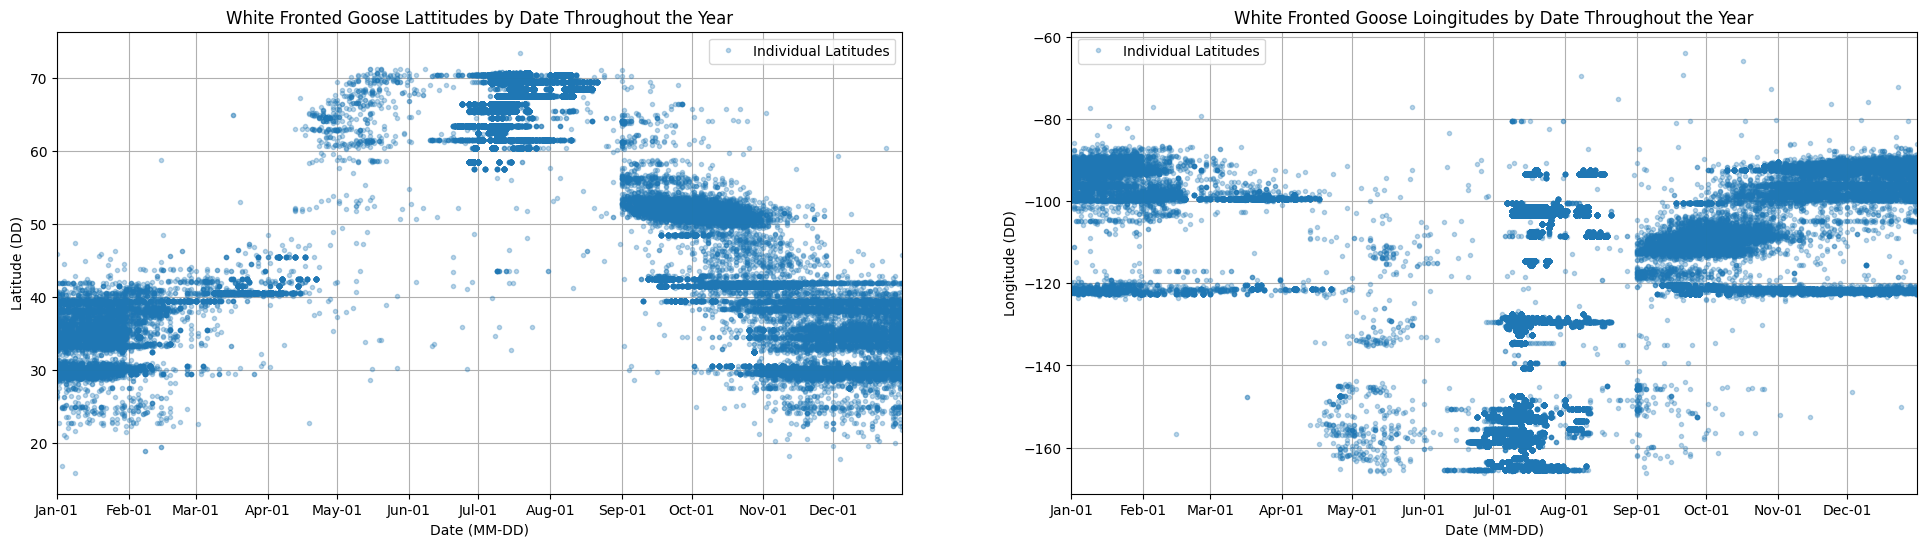

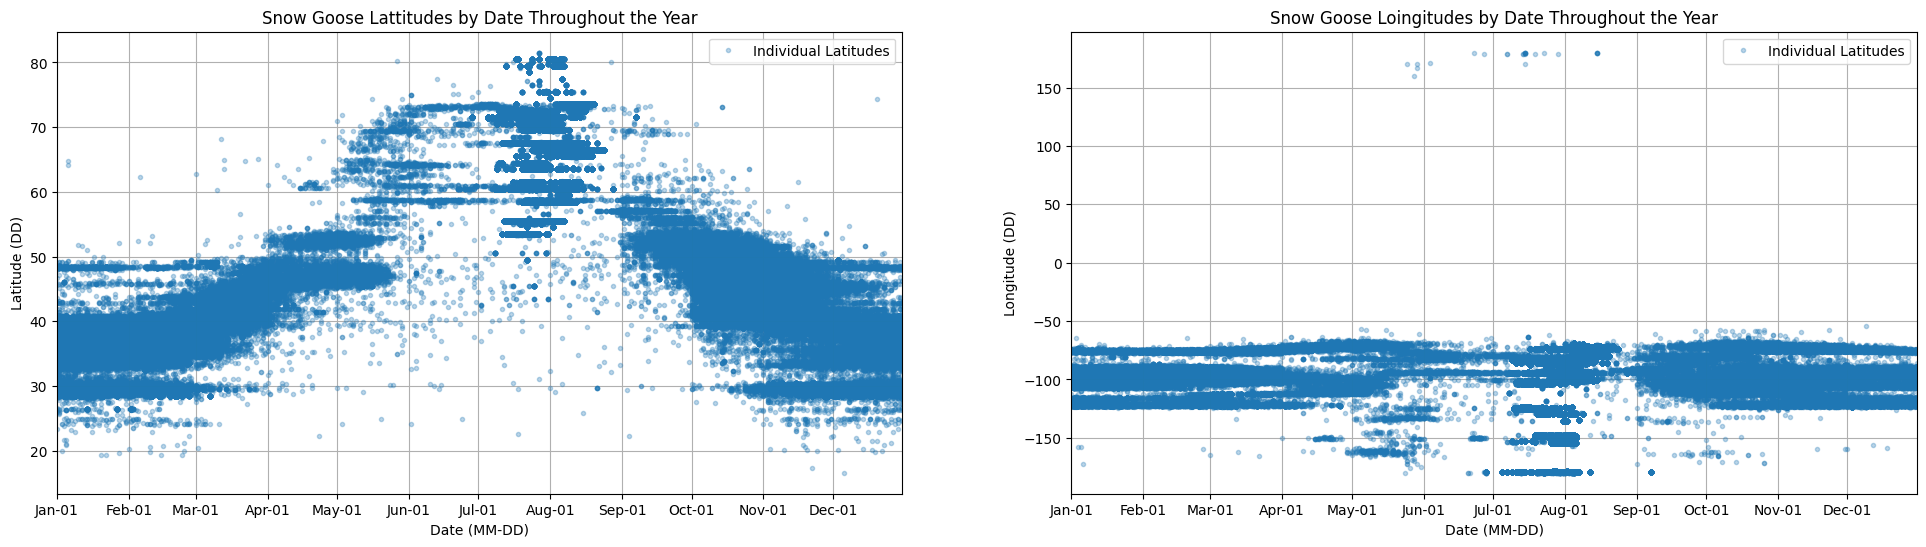

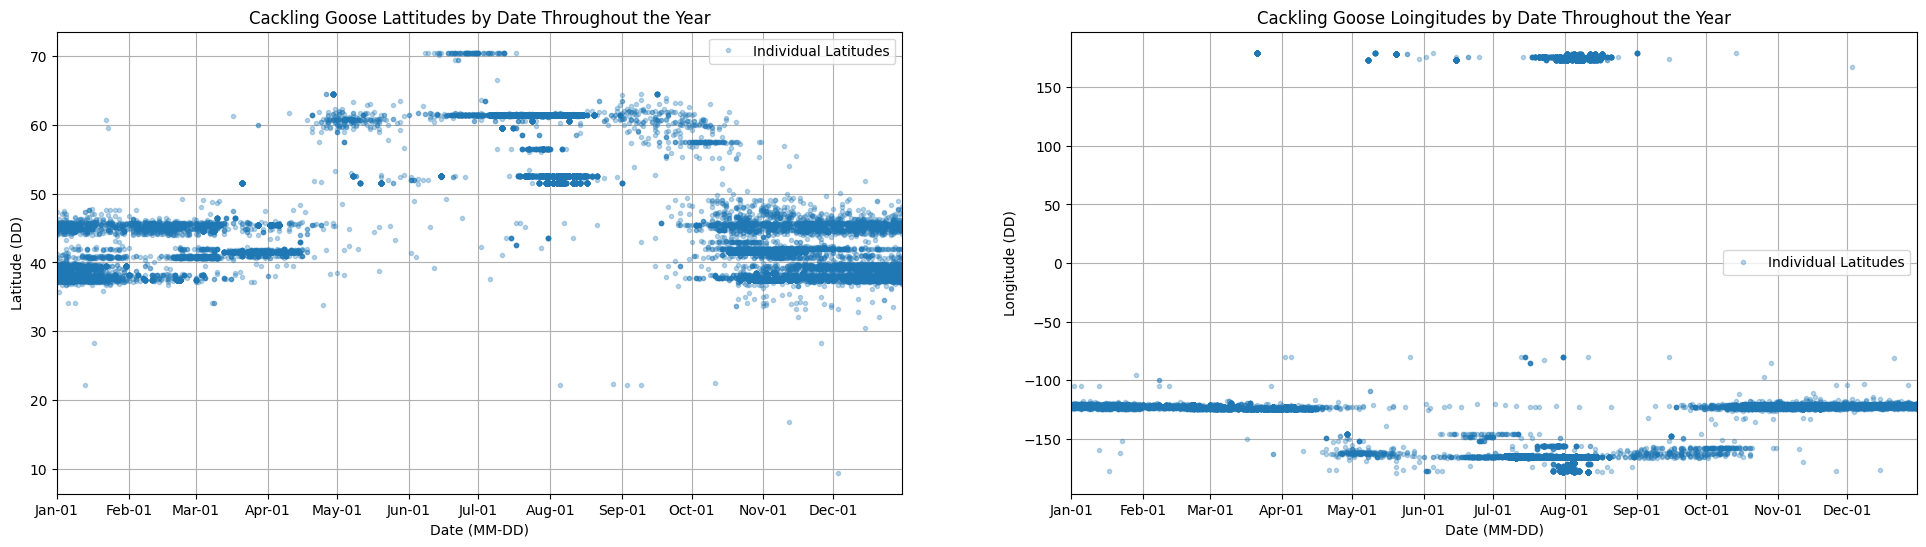

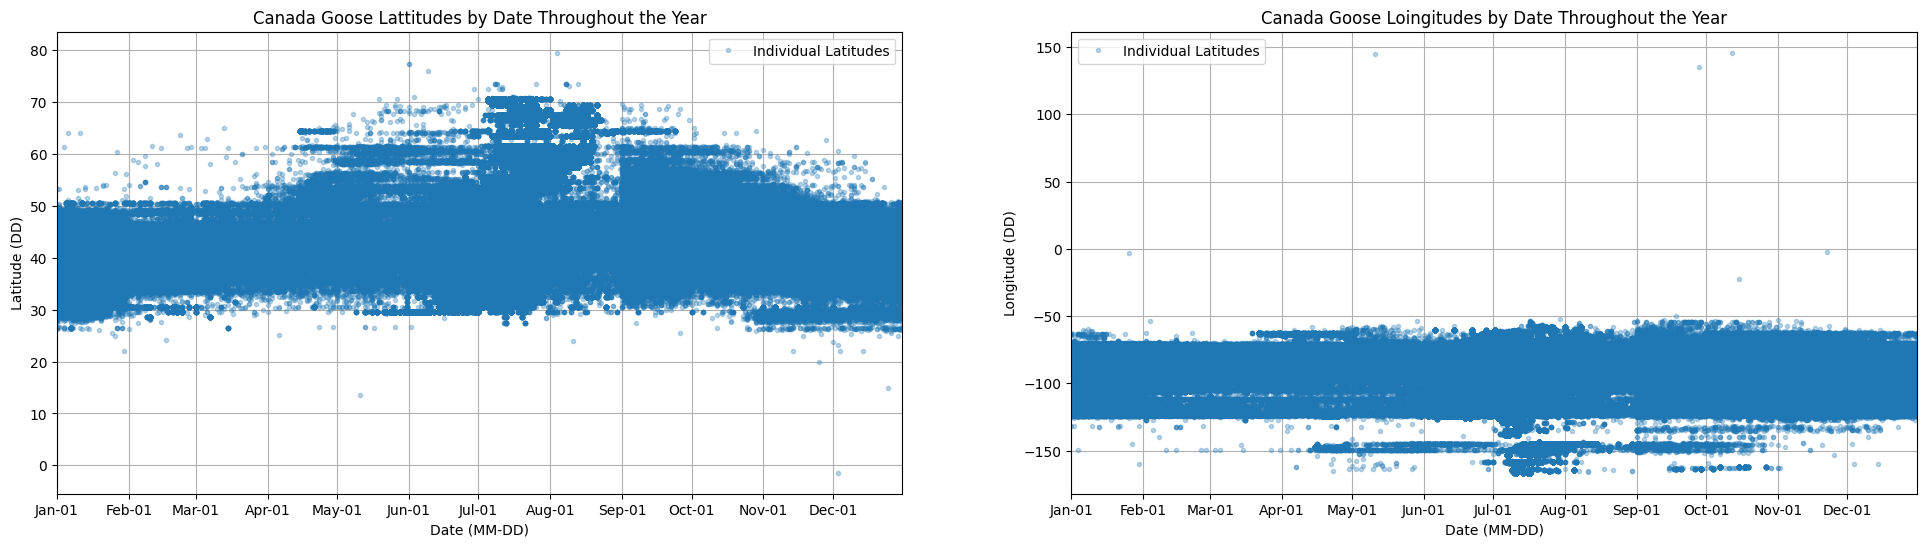

In [41]:
#
# Plot the latitudes and longitudes by date throughout the year
#

def scatter_data(goose_data, goose_name = ''):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(24, 6))
    fmt = mdates.DateFormatter("%b-%d")

    #
    # Plot lattitudes by date excluding the year.
    #
    ax1.plot(goose_data['EVENT_DATE'].apply(lambda x : x.replace(year = 2000)), goose_data['LAT_DD'], marker='.', linestyle='None', alpha=0.3, label='Individual Latitudes')
    ax1.xaxis.set_major_formatter(fmt)
    ax1.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
    ax1.set_xlim([datetime(2000, 1, 1), datetime(2000, 12, 31)])
    ax1.set_xlabel('Date (MM-DD)')
    ax1.set_ylabel('Latitude (DD)')
    ax1.legend()
    ax1.set_title(f'{goose_name} Lattitudes by Date Throughout the Year')
    ax1.grid()

    #
    # Plot longitudes by date excluding the year.
    #
    ax2.plot(goose_data['EVENT_DATE'].apply(lambda x : x.replace(year = 2000)), goose_data['LON_DD'], marker='.', linestyle='None', alpha=0.3, label='Individual Latitudes')
    ax2.xaxis.set_major_formatter(fmt)
    ax2.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
    ax2.set_xlim([datetime(2000, 1, 1), datetime(2000, 12, 31)])
    ax2.set_xlabel('Date (MM-DD)')
    ax2.set_ylabel('Longitude (DD)')
    ax2.legend()
    ax2.set_title(f'{goose_name} Loingitudes by Date Throughout the Year')
    ax2.grid()
    plt.show()

scatter_data(white_fronted_goose_data, 'White Fronted Goose')
scatter_data(snow_goose_data, 'Snow Goose')
scatter_data(cackling_goose_data, 'Cackling Goose')
scatter_data(canada_goose_data, 'Canada Goose')

There seems to be a significant difference between how locations are distributed throughout the year, but let's verify that first. To do this, let's consider the following method.
1. See if the lattitudes and longitudes of geese differ significantly between months.

The first formulation looks directly at the lattitude and longitude data, and thus will require a test the satisfies the following requirements:
1. The test must be able to compare between more than two samples
2. The test must not require the assumption that the data is normally distributed
3. The test must be able to handle continuous data

#### 2.1.2: Mood's Median

Before choosing a test, we need to consider if there are any outliers in the lattitude and longitude data. To do this, we make a box plot of the data.

In [42]:
#
# Group data into months
#

def get_months(goose_data):
    months_dict = goose_data.groupby('EVENT_MONTH')

    # Prepare lists containing lattidue and longitude data from each month
    lat_sample = [group['LAT_DD'].values for _, group in months_dict]
    lon_sample = [group['LON_DD'].values for _, group in months_dict]

    return months_dict, lat_sample, lon_sample

white_fronted_goose_months_dict, white_fronted_goose_lat_sample, white_fronted_goose_lon_sample = get_months(white_fronted_goose_data)
snow_goose_months_dict, snow_goose_lat_sample, snow_goose_lon_sample = get_months(snow_goose_data)
cackling_goose_months_dict, cackling_goose_lat_sample, cackling_goose_lon_sample = get_months(cackling_goose_data)
canada_goose_months_dict, canada_goose_lat_sample, canada_goose_lon_sample = get_months(canada_goose_data)

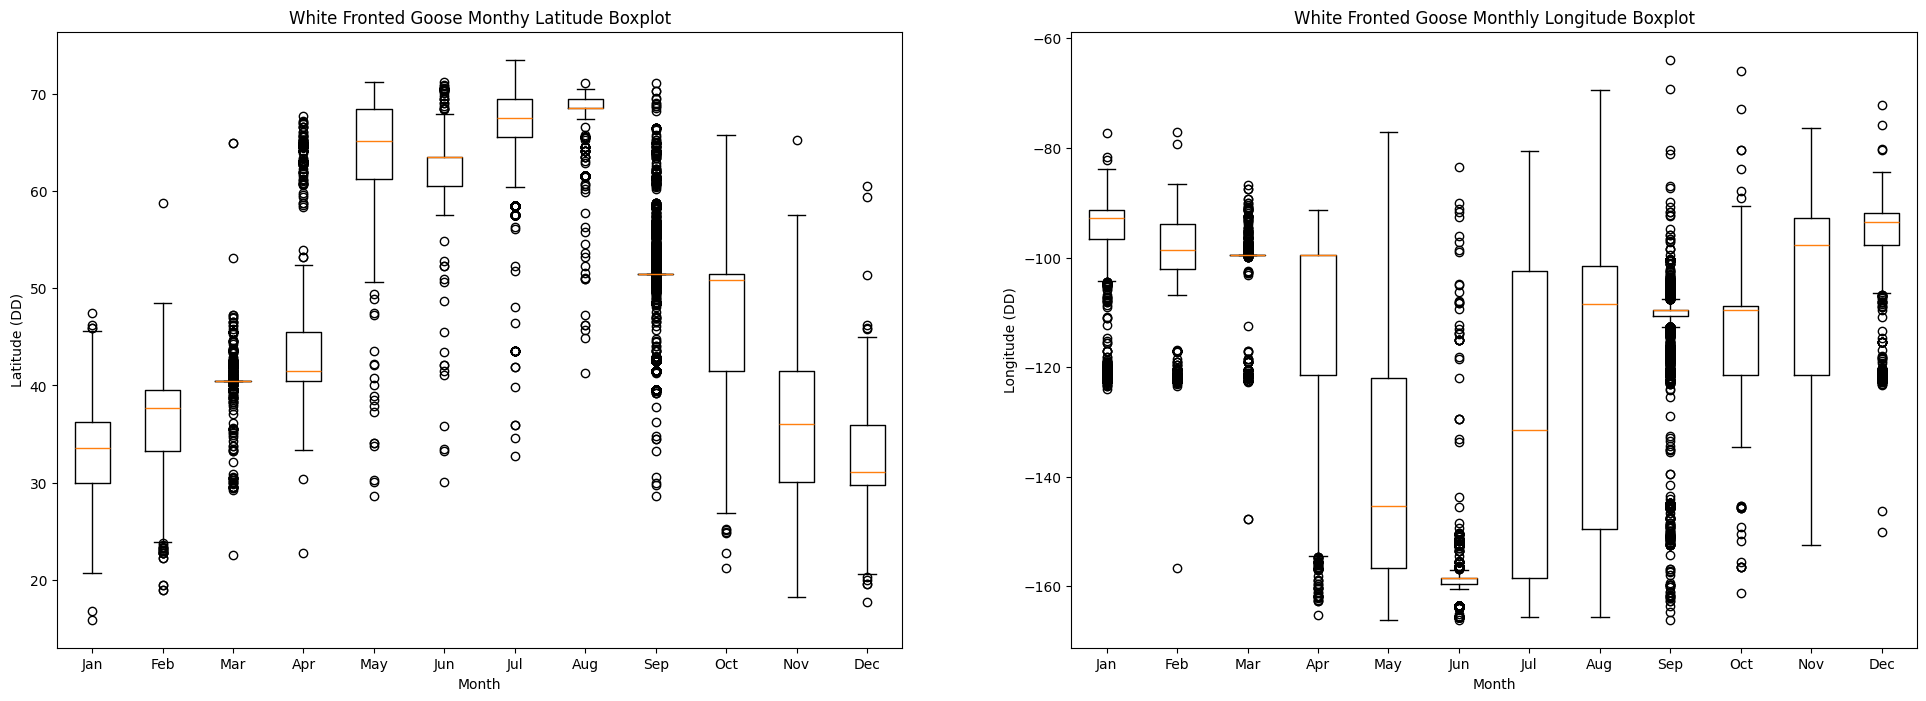

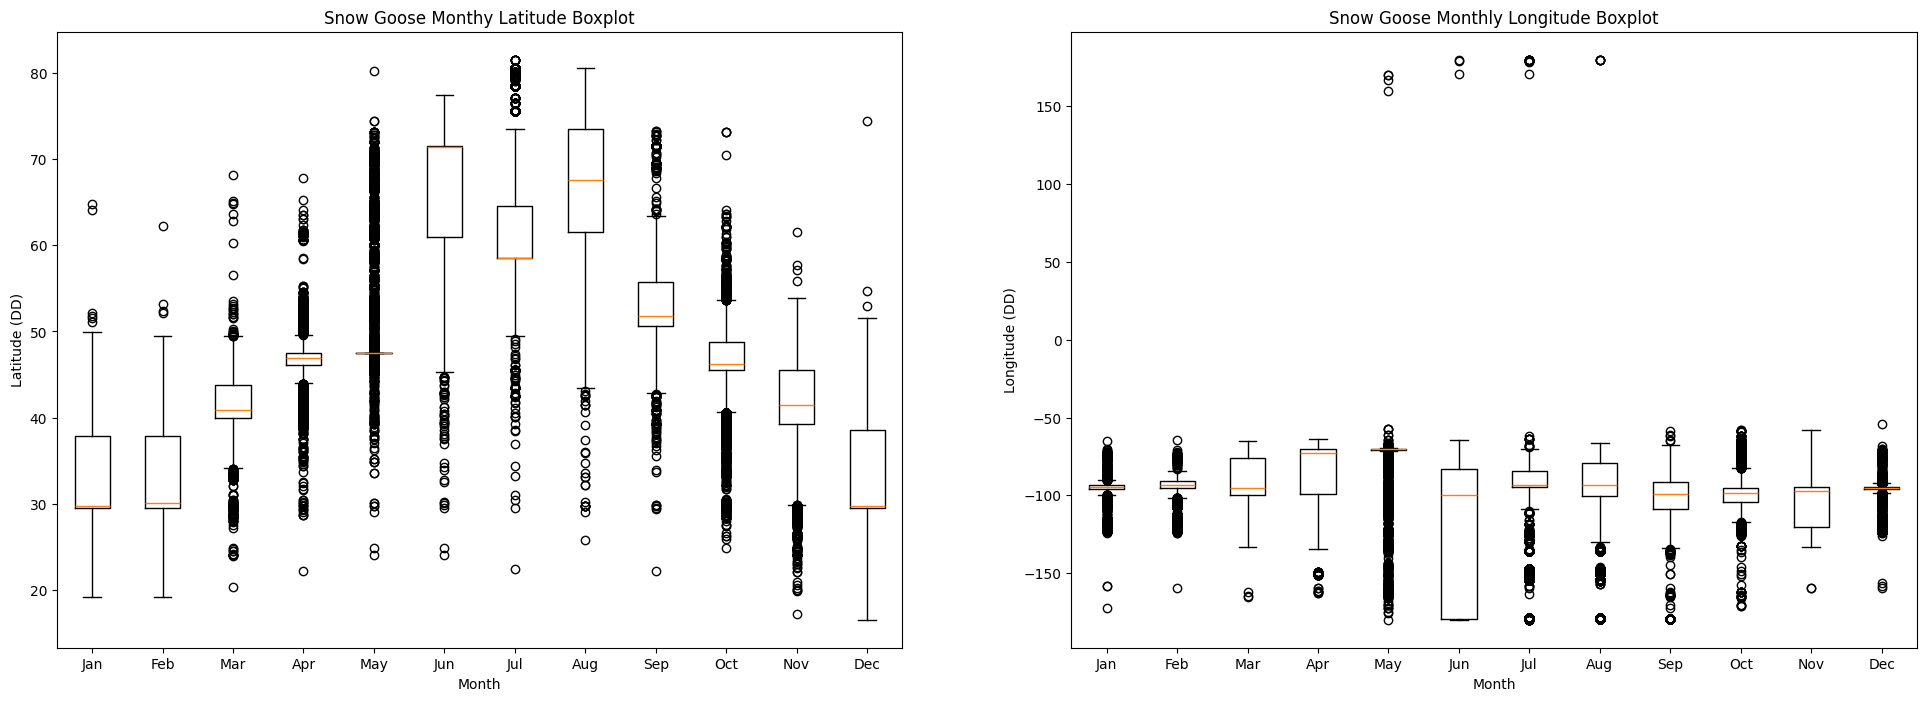

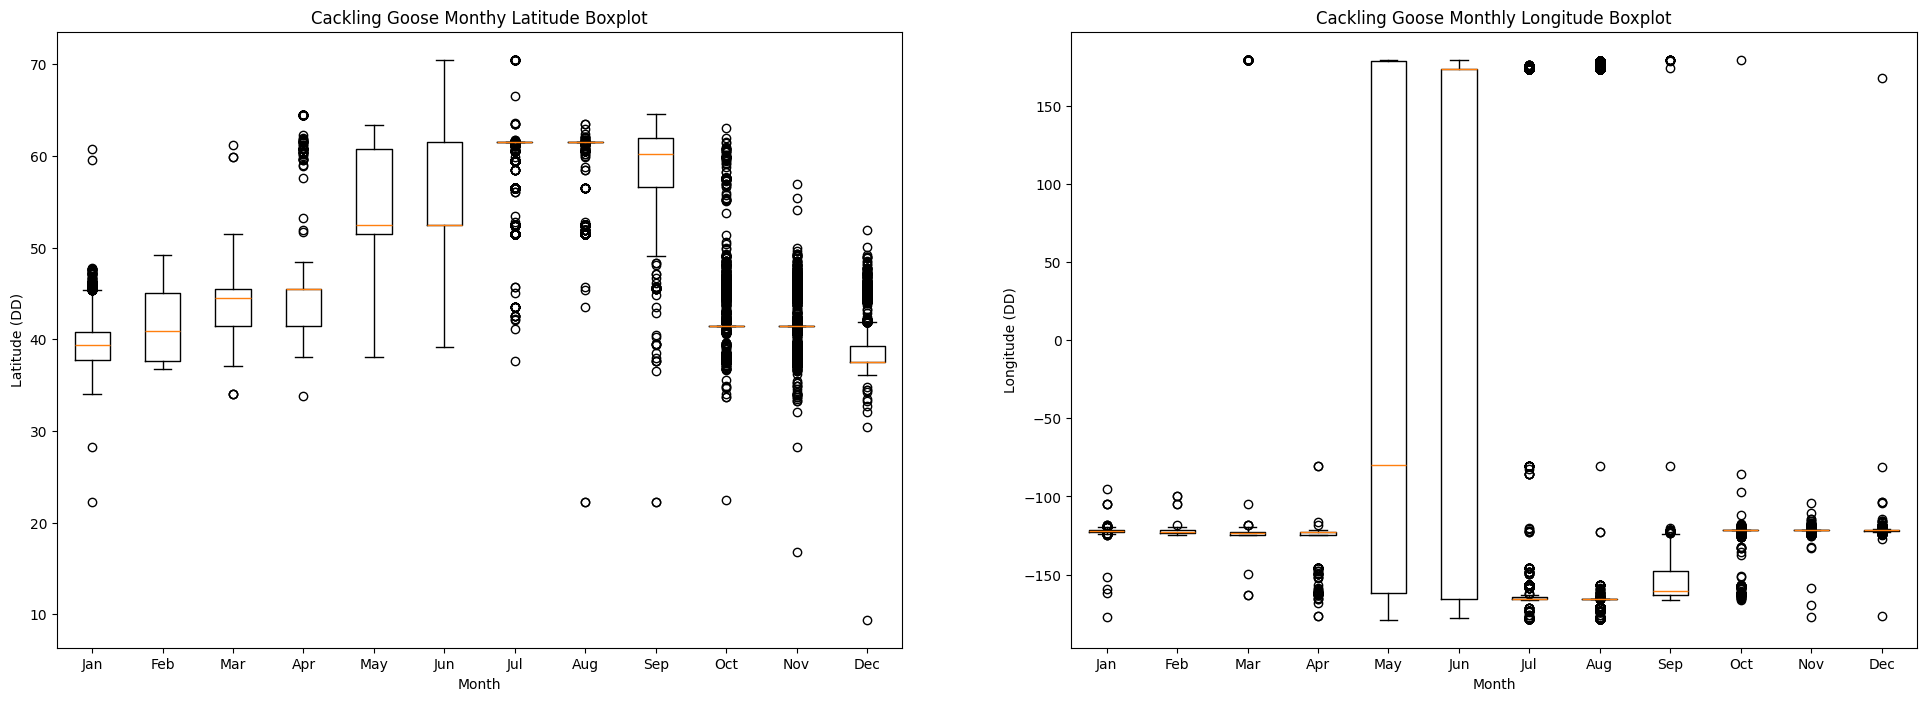

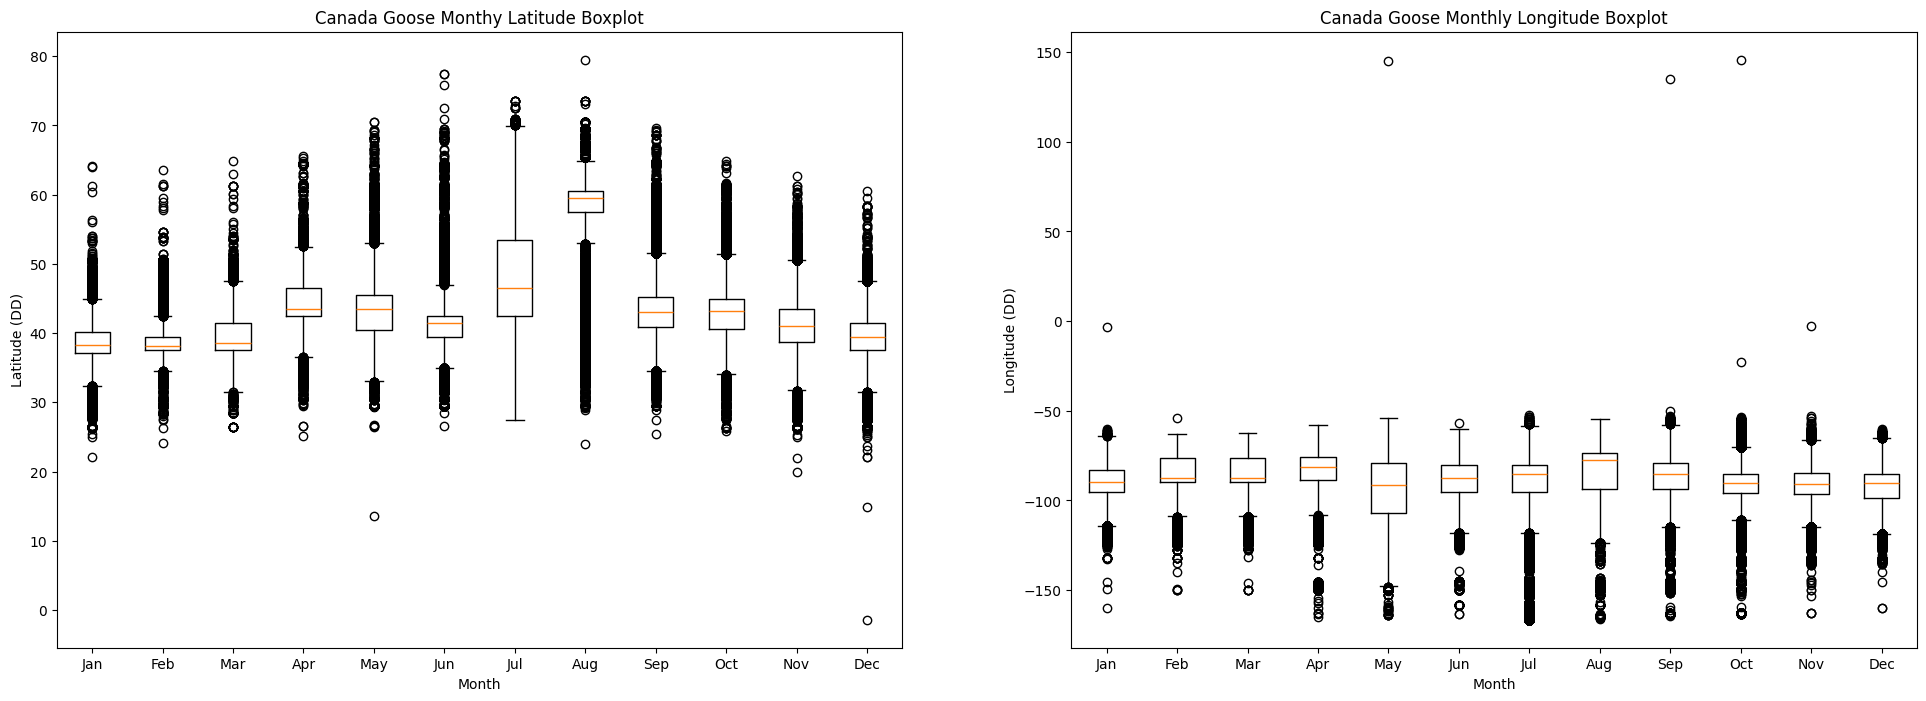

In [43]:
#
# Make boxplots of the latitudes and longitudes by month
#

def make_boxplots(goose_data, lat_sample, lon_sample, goose_name = ''):
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 8))

    ax1.boxplot(lat_sample)
    ax1.set_xlabel('Month')
    ax1.set_ylabel('Latitude (DD)')
    ax1.set_xticklabels(months)
    ax1.set_title(f"{goose_name} Monthy Latitude Boxplot")

    ax2.boxplot(lon_sample)
    ax2.set_xlabel('Month')
    ax2.set_ylabel('Longitude (DD)')
    ax2.set_xticklabels(months)
    ax2.set_title(f"{goose_name} Monthly Longitude Boxplot")

    plt.show()

make_boxplots(white_fronted_goose_data, white_fronted_goose_lat_sample, white_fronted_goose_lon_sample, 'White Fronted Goose')
make_boxplots(snow_goose_data, snow_goose_lat_sample, snow_goose_lon_sample, 'Snow Goose')
make_boxplots(cackling_goose_data, cackling_goose_lat_sample, cackling_goose_lon_sample, 'Cackling Goose')
make_boxplots(canada_goose_data, canada_goose_lat_sample, canada_goose_lon_sample, 'Canada Goose')

It seems we have a large number of outliers in out data, so we also need a test that can handle the presence of outliers.

This means there is one test we should run here. The Mood's Median Test.

#### 2.1.3: Mood's Median Testing

For the Mood's Median Test, will compare the median location of the bird over all datapoints taken within each month of the year. The median location here will be defined as the location whose lattitude is the median lattitude and whose longitude is the meadian longitude. We will also define locations being significantly different to mean that either the lattitude or longitude differs significantly.

For this test, we have the following hypotheses:

Null Hypothesis ($H_0$): There is no significant differnce between the median positions (no difference between median lattitude and longitude) of the Goose species between any two months.

Alternate Hypothesis ($H_A$): This is a significant differnce between the median positions (difference between median lattitude and longitude) of the Goose species between some pairs of months.

In [44]:
#
# Perform the Mood's Median test on latitude and longitude data
#

def do_moods_median_test(lat_sample, lon_sample, goose_name = ''):
    # Perform the Mood's Median test on latitude and longitude data and thank scipy for not making me do it manually
    lat_p_value = stats.median_test(*lat_sample).pvalue
    lon_p_value = stats.median_test(*lon_sample).pvalue

    # Print out the results
    print(f"Mood's Median test on {goose_name} for lattitude p-value: {lat_p_value}")
    print(f"Mood's Median test on {goose_name} for longitude p-value: {lon_p_value}")

do_moods_median_test(white_fronted_goose_lat_sample, white_fronted_goose_lon_sample, 'White Fronted Goose')
do_moods_median_test(snow_goose_lat_sample, snow_goose_lon_sample, 'Snow Goose')
do_moods_median_test(cackling_goose_lat_sample, cackling_goose_lon_sample, 'Cackling Goose')
do_moods_median_test(canada_goose_lat_sample, canada_goose_lon_sample, 'Canada Goose')

Mood's Median test on White Fronted Goose for lattitude p-value: 0.0
Mood's Median test on White Fronted Goose for longitude p-value: 0.0
Mood's Median test on Snow Goose for lattitude p-value: 0.0
Mood's Median test on Snow Goose for longitude p-value: 0.0
Mood's Median test on Cackling Goose for lattitude p-value: 0.0
Mood's Median test on Cackling Goose for longitude p-value: 0.0
Mood's Median test on Canada Goose for lattitude p-value: 0.0
Mood's Median test on Canada Goose for longitude p-value: 0.0


As seen above, the Mood's Median $p$ values for both lattitude and longitude are extremely small across all species (all too small for Python to properly store). This means that the median location of the all Goose species differ significantly between at least two months since the $p$ value is clearly smaller than $0.05$, the threshold required to reject the null hypothesis $H_0$. Therefore we can only conclude that $H_A$ is true.

#### 2.1.3: Post Hoc Analysis

Since $H_0$ was rejected, a post-hoc analysis of all four datasets is at hand. This will be a series of $\frac{11(11+1)}{2} = 66$ sets of null and alternate hypotheses (denoted as $H_{0, i, j}$ and $H_{A, i, j}$ for $i, j \in \{1, 2, ..., 12 \} | i \neq j$) defined as follows:

Null Hypothesis ($H_{0, i, j}$): The median position in month $i$ does not differ significantly from $j$.

Alternate Hypothesis ($H_{A, i, j}$): The median position in month $i$ differs significantly from $j$.

This will be tested with Mann-Witney U Tests as our data isn't neccesarily normally distributed. The condition for rejecting the null is set to be $p < 0.05$ for either lattitude or longitude.

In [45]:
def post_hoc_mood(months_dict, goose_name = ''):
    #
    # Perform the Mann-Whitney U test for each pair of months
    #

    # Initialize a 12x12 matrix to store the results of the Mann-Whitney U test
    mann_whitney_results = np.full((12, 12), None, dtype=object)

    # Perform the Mann-Whitney U test for each relevant pair of months
    for i in range(0, 12):
        for j in range(i + 1, 12):
            lat_stat, lat_p_value = stats.mannwhitneyu(months_dict.get_group(i + 1)['LAT_DD'], months_dict.get_group(j + 1)['LAT_DD'], alternative='two-sided')
            lon_stat, lon_p_value = stats.mannwhitneyu(months_dict.get_group(i + 1)['LON_DD'], months_dict.get_group(j + 1)['LON_DD'], alternative='two-sided')
            mann_whitney_results[i][j] = (lat_stat, lat_p_value, lon_stat, lon_p_value)

    # Store the results into a DataFrame for better visualization
    mann_whitney_df = pd.DataFrame(mann_whitney_results, index=range(1, 13), columns=range(1, 13))

    # Extract the relevant statistics and p-values from the DataFrame
    mw_lat_stat_df = mann_whitney_df.map(lambda x: x[0] if x is not None else None)
    mw_lat_p_df = mann_whitney_df.map(lambda x: x[1] if x is not None else None)
    mw_lon_stat_df = mann_whitney_df.map(lambda x: x[2] if x is not None else None)
    mw_lon_p_df = mann_whitney_df.map(lambda x: x[3] if x is not None else None)

    # Table whose values correspond to whether the null hypothesis can be rejected for each pair of months
    mw_lat_h0_reject_df = mann_whitney_df.map(lambda x: x[1] < 0.05 if x is not None else None)
    mw_lon_h0_reject_df = mann_whitney_df.map(lambda x: x[3] < 0.05 if x is not None else None)
    mw_h0_reject_df = mann_whitney_df.map(lambda x: x[1] < 0.05 and x[3] < 0.05 if x is not None else None)

    print(f'Post-hoc for {goose_name}')
    # Display the results
    #     True  -> Reject Null
    #     False -> Fail to Reject
    #      None -> Not Tested
    display(mw_h0_reject_df)

post_hoc_mood(white_fronted_goose_months_dict, 'White Fronted Goose')
post_hoc_mood(snow_goose_months_dict, 'Snow Goose') 
post_hoc_mood(cackling_goose_months_dict, 'Cackling Goose')
post_hoc_mood(canada_goose_months_dict, 'Canada Goose')

Post-hoc for White Fronted Goose


,1,2,3,4,5,6,7,8,9,10,11,12
1,None,True,True,True,True,True,True,True,True,True,True,True
2,None,None,True,True,True,True,True,True,True,True,False,True
3,None,None,None,True,True,True,True,True,True,True,True,True
4,None,None,None,None,True,True,True,True,True,True,True,True
5,None,None,None,None,None,True,True,True,True,True,True,True
6,None,None,None,None,None,None,True,True,True,True,True,True
7,None,None,None,None,None,None,None,True,True,True,True,True
8,None,None,None,None,None,None,None,None,True,True,True,True
9,None,None,None,None,None,None,None,None,None,False,True,True
10,None,None,None,None,None,None,None,None,None,None,True,True


Post-hoc for Snow Goose


,1,2,3,4,5,6,7,8,9,10,11,12
1,None,True,True,True,True,True,True,True,True,True,True,False
2,None,None,True,True,True,True,True,True,True,True,True,True
3,None,None,None,True,True,True,True,True,True,True,True,True
4,None,None,None,None,True,True,True,True,True,True,True,True
5,None,None,None,None,None,True,True,True,True,True,True,True
6,None,None,None,None,None,None,True,True,True,True,True,True
7,None,None,None,None,None,None,None,True,True,True,True,True
8,None,None,None,None,None,None,None,None,True,True,True,True
9,None,None,None,None,None,None,None,None,None,True,True,True
10,None,None,None,None,None,None,None,None,None,None,False,True


Post-hoc for Cackling Goose


,1,2,3,4,5,6,7,8,9,10,11,12
1,None,True,True,True,False,True,True,True,True,True,True,True
2,None,None,True,True,False,False,True,True,True,False,True,True
3,None,None,None,True,False,False,True,True,True,True,True,True
4,None,None,None,None,True,True,True,True,True,True,True,True
5,None,None,None,None,None,True,True,True,True,False,False,False
6,None,None,None,None,None,None,True,True,False,True,True,True
7,None,None,None,None,None,None,None,True,True,True,True,True
8,None,None,None,None,None,None,None,None,True,True,True,True
9,None,None,None,None,None,None,None,None,None,True,True,True
10,None,None,None,None,None,None,None,None,None,None,True,True


Post-hoc for Canada Goose


,1,2,3,4,5,6,7,8,9,10,11,12
1,None,True,True,True,True,True,True,True,True,True,True,True
2,None,None,True,True,True,True,True,True,True,True,True,True
3,None,None,None,True,True,True,True,True,True,True,True,True
4,None,None,None,None,True,True,True,False,True,True,True,True
5,None,None,None,None,None,True,True,True,False,False,True,True
6,None,None,None,None,None,None,True,True,True,True,True,True
7,None,None,None,None,None,None,None,True,True,True,True,True
8,None,None,None,None,None,None,None,None,True,True,True,True
9,None,None,None,None,None,None,None,None,None,True,True,True
10,None,None,None,None,None,None,None,None,None,None,True,True


For the White-Fronted Goose, we can see that there is a significant difference between the locations of the geese for all pairs of months except for September-October and Feburary-November, so we can see that this species of bird moves over the course of a year.

For the Snow Goose, we see that there is a significant difference between the locations of the geese for all pairs of months except for October-November and December-Janurary, so we can see that this species of bird also moves over the course of a year.

For the Cackling Goose, we see that there is a significant difference between the locations of the geese for many pairs of months, so we can see that this species of bird also moves over the course of a year.

For the Canada Goose, we see that there is a significant difference between the locations of the geese for many pairs of months, so we can see that this species of bird also moves over the course of a year.

### 2.2: Does the Average Location of the Geese in a Given Month Differ Between Decades?

For this, we only compare the data between the earliest decade (1960-1969) and the latest decade (2010-2019).

Before we choose a test, let's consider plotting the data. Since the plot can get messy quickly as seen in the previous section, we will only plot samples ($n=50,000$) of the data.

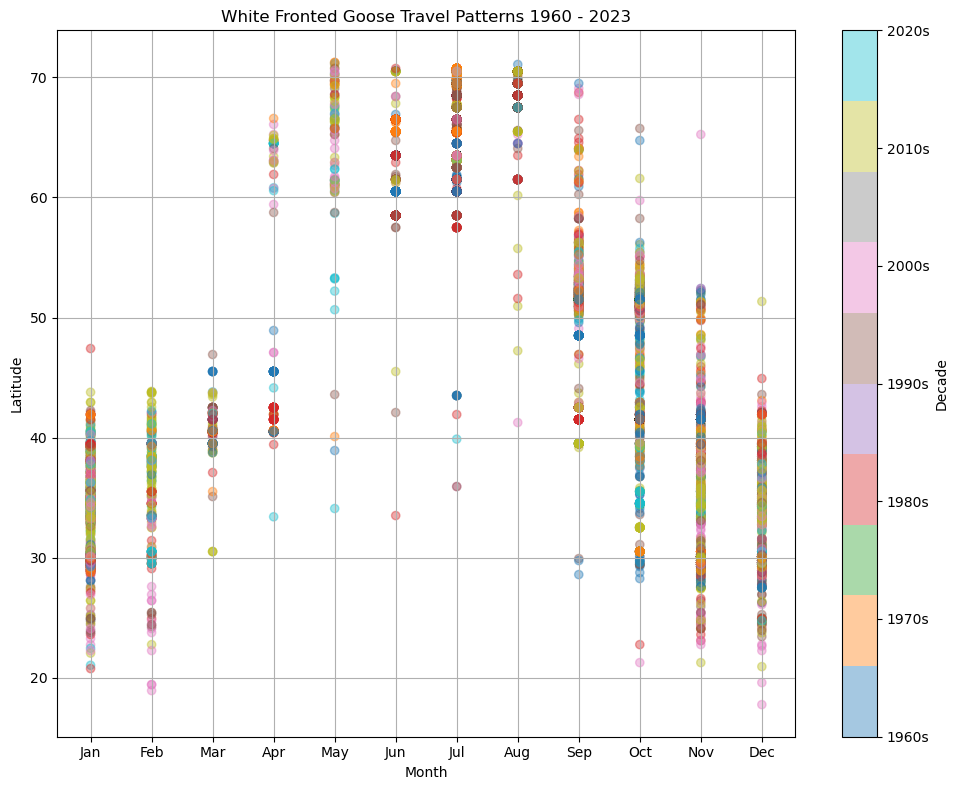

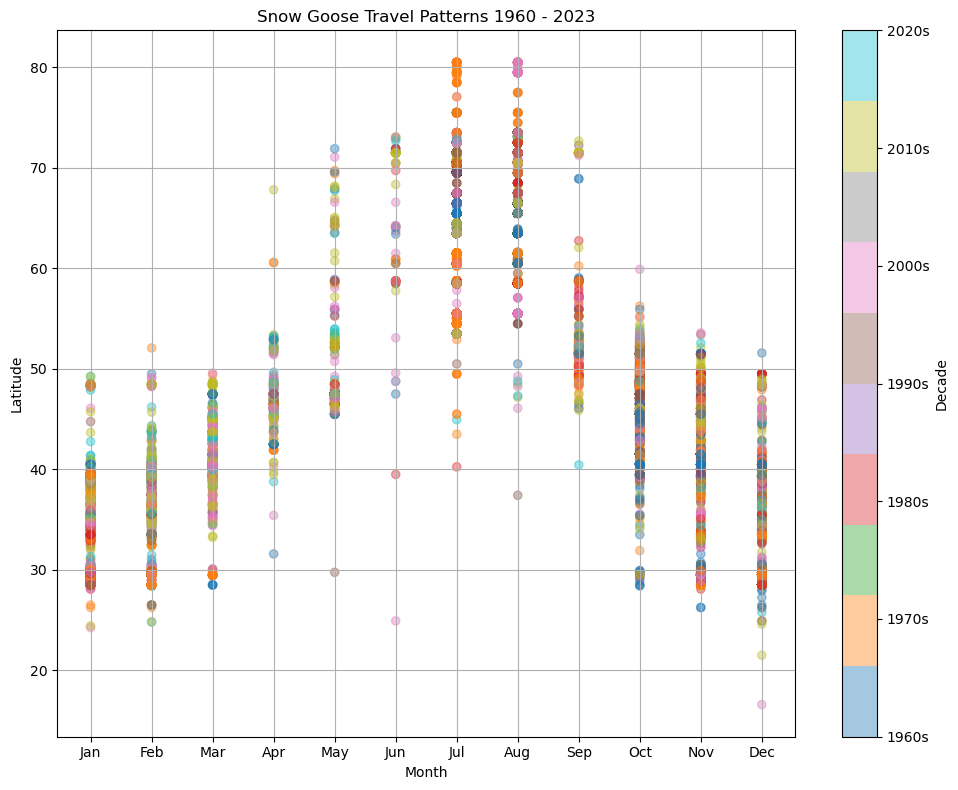

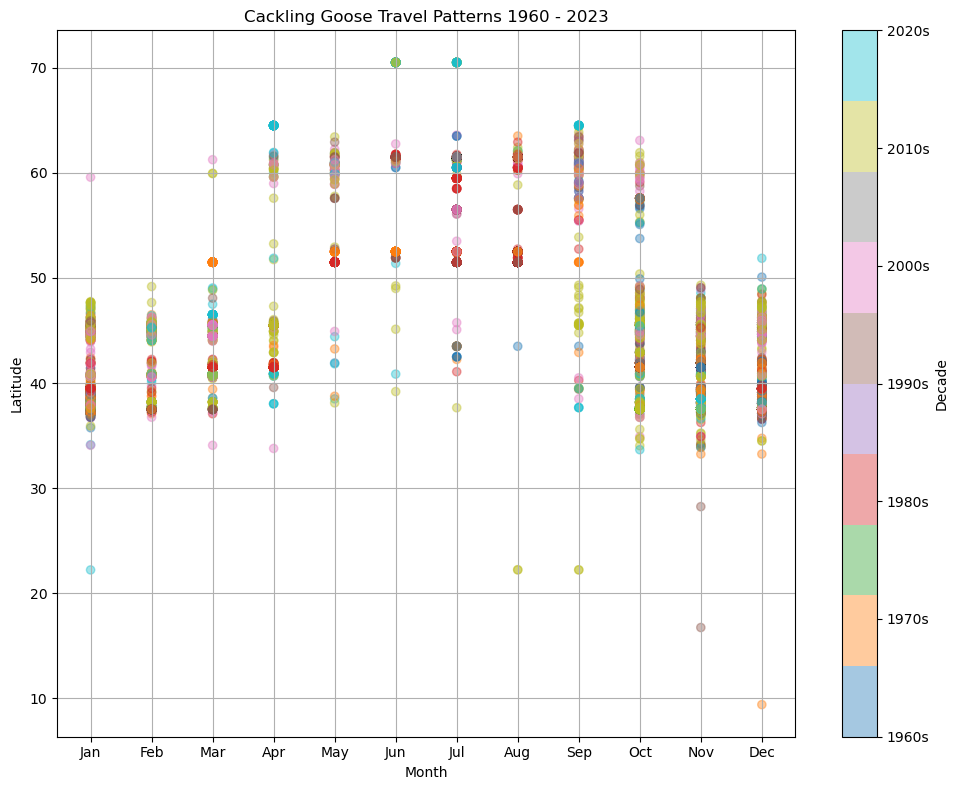

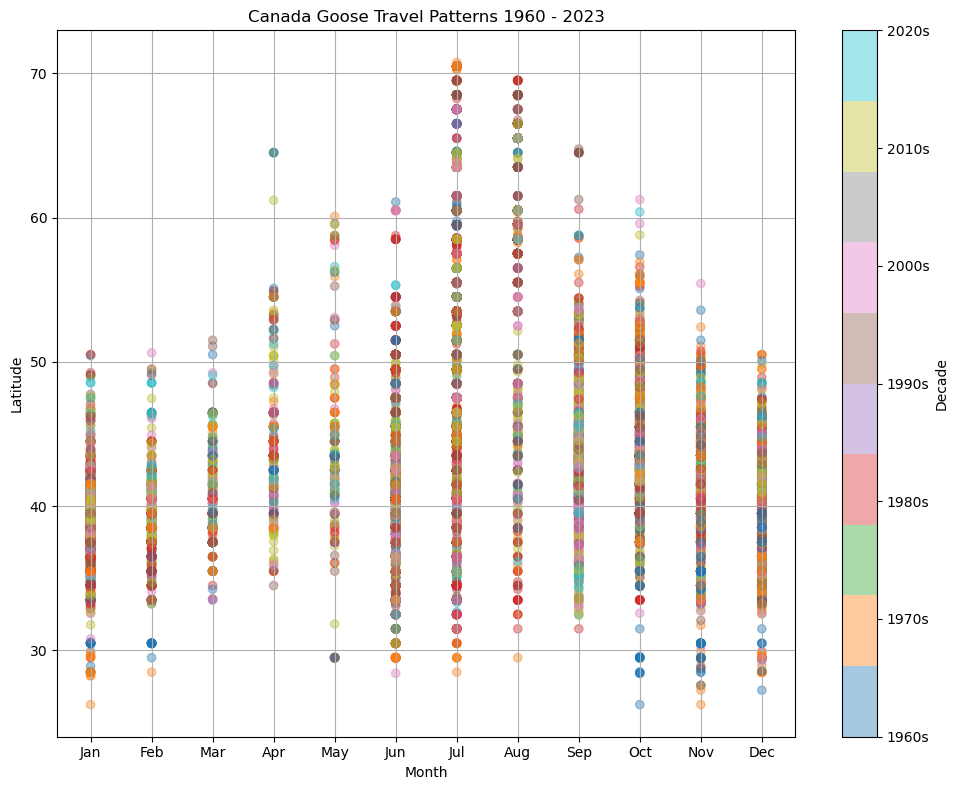

In [31]:

def decade_scatter_plot(goose_data, goose_name = ''):
    sampled_geese = goose_data
    sampled_geese['DECADE'] = (sampled_geese['EVENT_YEAR'] // 10) * 10

    sampled_geese = sampled_geese.sample(n=50000, random_state=33) #33 cause it's my favorite number

    plt.figure(figsize=(10,8))
    scatter =plt.scatter(
        x = sampled_geese['EVENT_MONTH'],
        y = sampled_geese['LAT_DD'],
        c = sampled_geese['DECADE'],
        cmap = 'tab10',
        alpha = 0.4,
    )
    plt.xlabel("Month")
    plt.xticks(ticks=range(1,13), labels=['Jan','Feb', 'Mar', 'Apr', 'May', 'Jun',
                                       'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    plt.ylabel('Latitude')
    plt.title(f"{goose_name} Travel Patterns 1960 - 2023")
    plt.grid(True)
    plt.tight_layout()

    cbar = plt.colorbar(scatter, ticks=sorted(sampled_geese['DECADE'].unique()))
    cbar.set_label('Decade')
    cbar.set_ticklabels(f"{d}s" for d in sorted(sampled_geese['DECADE'].unique()))

    plt.show()
    
    return sampled_geese

sampled_white_fronted_goose = decade_scatter_plot(white_fronted_goose_data, 'White Fronted Goose')
sampled_snow_goose = decade_scatter_plot(snow_goose_data, 'Snow Goose') 
sampled_cackling_goose = decade_scatter_plot(cackling_goose_data, 'Cackling Goose')
sampled_canada_goose = decade_scatter_plot(canada_goose_data, 'Canada Goose')

We can clearly see that each month from 50,000 sightings/captures of geese from 1960 to 2023, that the average latitude rises during the summer months of the northen hemisphere. Roughly from April to mid August the latitude rises. Showing a trend in Migration where geese travel north during summer and south during winter. This becomes alittle clearer when looking at the fit lines for this data.

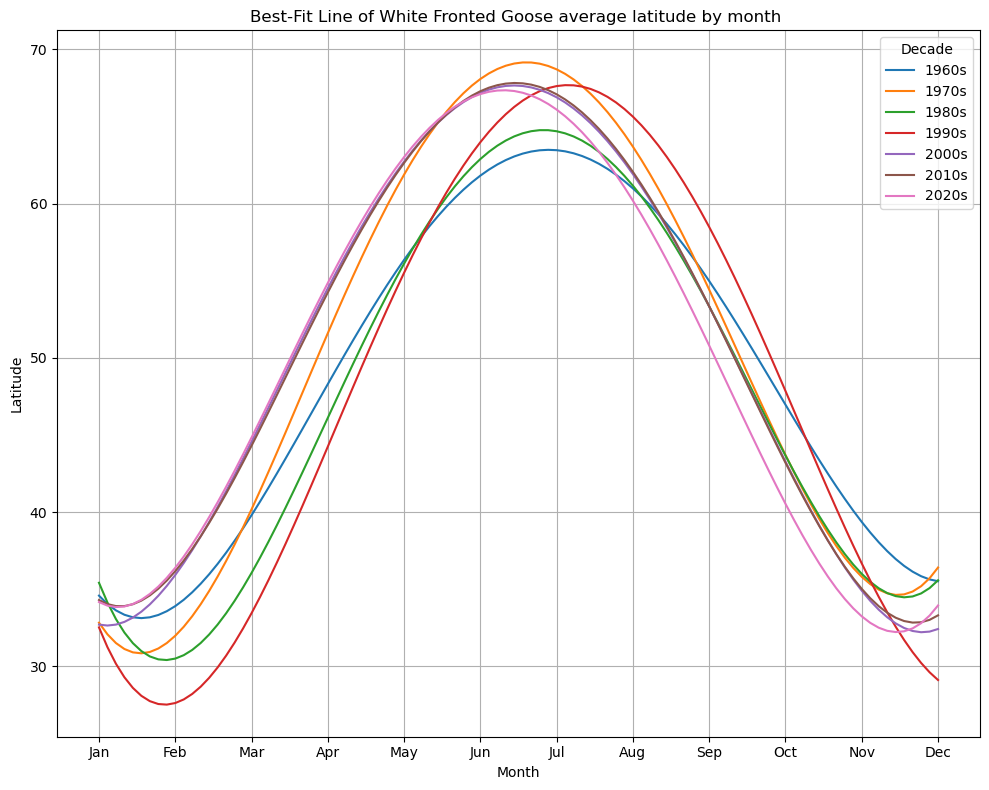

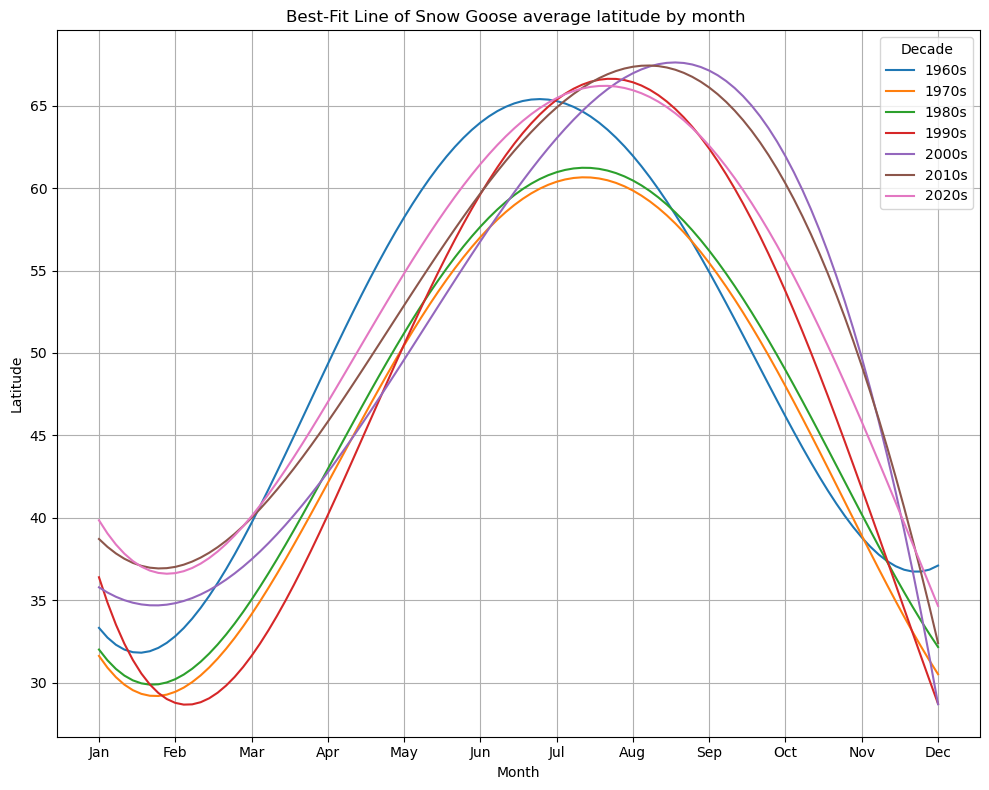

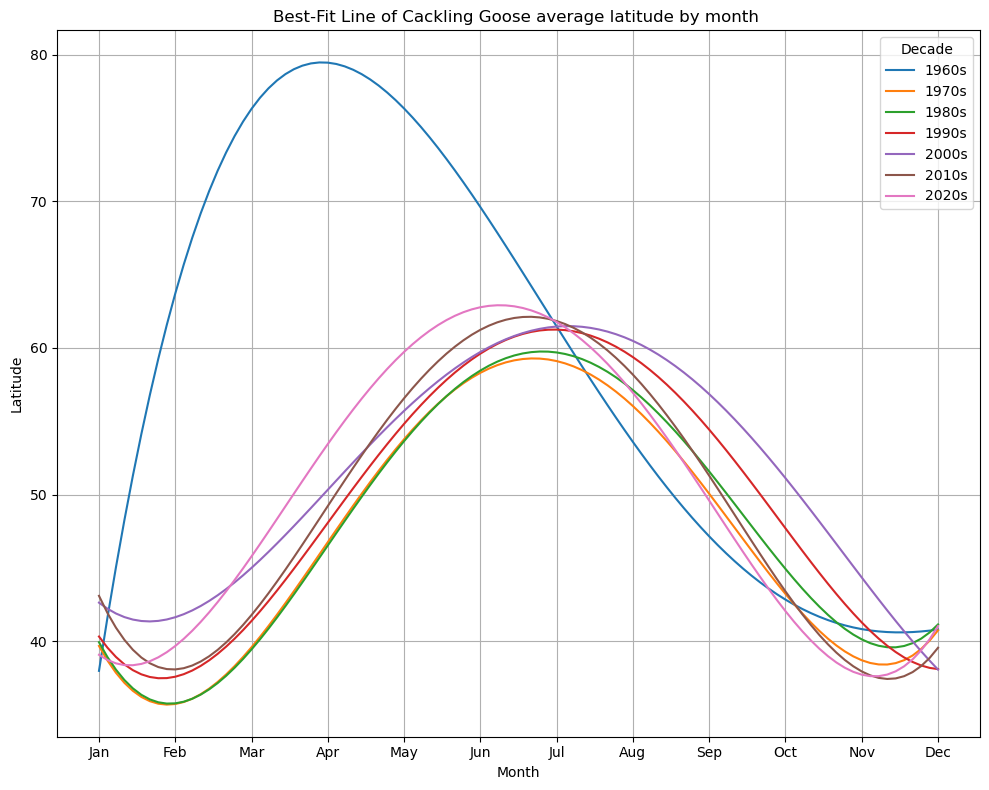

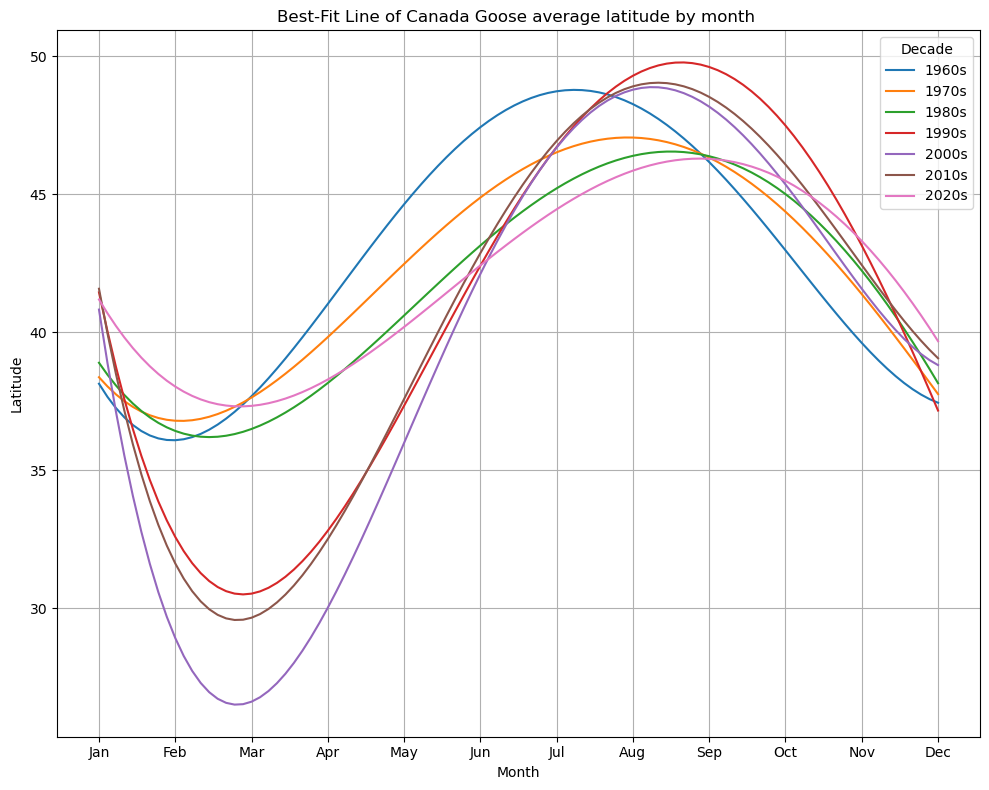

In [ ]:
def plot_fits(sampled_geese, goose_name = ''):
    decades = sorted(sampled_geese['DECADE'].unique())

    plt.figure(figsize=(10,8))

    for decade in decades:
        decade_df= sampled_geese[sampled_geese['DECADE'] == decade]
    
        x = decade_df['EVENT_MONTH']
        y = decade_df['LAT_DD']

        coeffs = np.polyfit(x, y, deg=4)
        a, b, c, d, e = coeffs #since data seems parabolic use 2 degrees

        x_fit = np.linspace(1, 12, 100)
        #equation for Quartic line graph
        y_fit = a * x_fit**4 + b * x_fit**3 + c * x_fit **2 + d * x_fit + e

        plt.plot(x_fit, y_fit, label = f"{decade}s")

    plt.xlabel("Month")
    plt.xticks(ticks=range(1,13), labels=['Jan','Feb', 'Mar', 'Apr', 'May', 'Jun',
                                       'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    plt.ylabel("Latitude")
    plt.legend(title='Decade')

    plt.title(f"Best-Fit Line of {goose_name} Average Latitude by Month ")

    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_fits(sampled_white_fronted_goose, 'White Fronted Goose')
plot_fits(sampled_snow_goose, 'Snow Goose')
plot_fits(sampled_cackling_goose, 'Cackling Goose')
plot_fits(sampled_canada_goose, 'Canada Goose')

Next let's see if these geese had a significant change in latitude as a function of the month in the last few decades. Based on the graph, we can see that the median position of the geese at a given month of the year seems to be roughly increaseing with each passing decade.

To do this, we will use a Z-Test to compare the lattitudes between the first and most recent decade. This means we have the following hypotheses for each goose species:

Null Hypothesis ($H_0$): The median latitude of the relevant goose species sightings between 1960 and 2023 in the month of July has not increased.

Alternate Hypothesis ($H_A$): The median latitude of the relevant goose species sightings between 1960 and 2023 in the month of July has increased.


In [35]:
def compare_july_latitudes(sampled_geese, goose_name = ''):
    july_1960s = sampled_geese[(sampled_geese['DECADE'] == 1960) & (sampled_geese['EVENT_MONTH'] == 7)]
    #we're using 2010s since 2020 only has 3 documented years
    july_2010s = sampled_geese[(sampled_geese['DECADE'] == 2010) & (sampled_geese['EVENT_MONTH'] == 7)]

    mean_2010s = july_2010s['LAT_DD'].mean()

    mean_1960s = july_1960s['LAT_DD'].mean()

    print(f"{goose_name} 2010s Mean: {mean_2010s}" )
    print(f"{goose_name} 1960s Mean: {mean_1960s}" )

    std_1960s = july_1960s['LAT_DD'].std()
    std_2010s = july_2010s['LAT_DD'].std()

    print(f"{goose_name} 2010s std: {std_2010s}" )
    print(f"{goose_name} 1960s std: {std_1960s}" )

    z = (mean_1960s - mean_2010s) / np.sqrt(((std_1960s ** 2)/len(july_1960s)) + ((std_2010s ** 2) / len(july_2010s)))

    p = 2 * (1 - norm.cdf(abs(z)))

    print(f"{goose_name} z value: {z}")
    print(f"{goose_name} P-value: {p}")

compare_july_latitudes(sampled_white_fronted_goose, 'White Fronted Goose')
compare_july_latitudes(sampled_snow_goose, 'Snow Goose')
compare_july_latitudes(sampled_cackling_goose, 'Cackling Goose')
compare_july_latitudes(sampled_canada_goose, 'Canada Goose')

White Fronted Goose 2010s Mean: 66.94373290322581
White Fronted Goose 1960s Mean: 64.44464965748824
White Fronted Goose 2010s std: 2.457318281851527
White Fronted Goose 1960s std: 3.9368131434904656
White Fronted Goose z value: -23.710278832801414
White Fronted Goose P-value: 0.0
Snow Goose 2010s Mean: 63.22479808496138
Snow Goose 1960s Mean: 65.21065026435734
Snow Goose 2010s std: 6.219330374930116
Snow Goose 1960s std: 4.099037079203996
Snow Goose z value: 12.791111035733946
Snow Goose P-value: 0.0
Cackling Goose 2010s Mean: 61.51488576367065
Cackling Goose 1960s Mean: 61.2483266398929
Cackling Goose 2010s std: 0.6395473463067936
Cackling Goose 1960s std: 2.123115915523799
Cackling Goose z value: -3.3954948522096537
Cackling Goose P-value: 0.0006850466206229644
Canada Goose 2010s Mean: 49.09502563774301
Canada Goose 1960s Mean: 51.56024783783784
Canada Goose 2010s std: 7.159403334688046
Canada Goose 1960s std: 8.777683956124404
Canada Goose z value: 6.272765770817306
Canada Goose P-v

As we can see the Z value we have calculated is far beyond the usual critical value of 1.96 for p < 0.05 for all four goose species.

Each of the goose species had a $p$ value lower than $0.05$, so we can reject $H_0$ and conclude that the average latitude of all tested geese species sighted between 1960 to 2023 Has **INCREASED** in The Month of July.

### 2.3: Question 3: Are the Sightings of Relevant Geese Species Uniform Across All Recorded Areas?

Now we consider if these sightings are uniformly distributed across all reocrded areas. To do this, we first create a heatmap representing a 2D histogram of all signtings in the data.

Creating heatmap with 218011 coordinate points


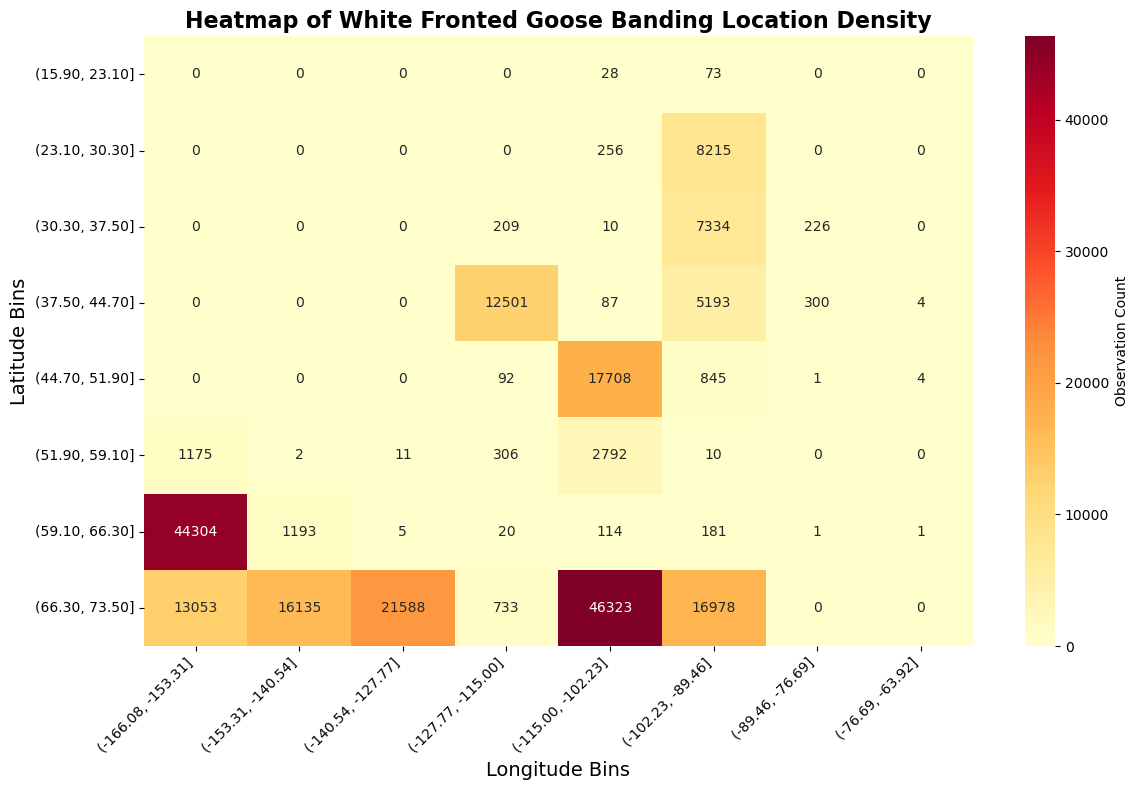

Creating heatmap with 1191034 coordinate points


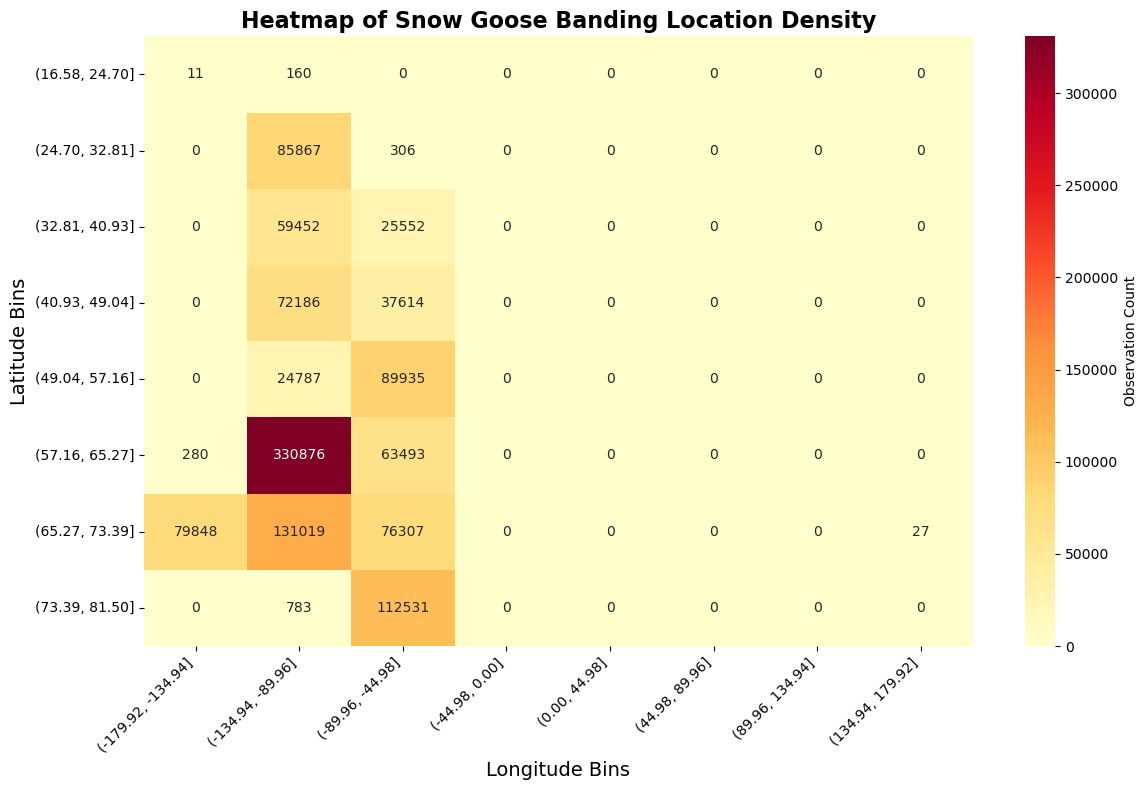

Creating heatmap with 72522 coordinate points


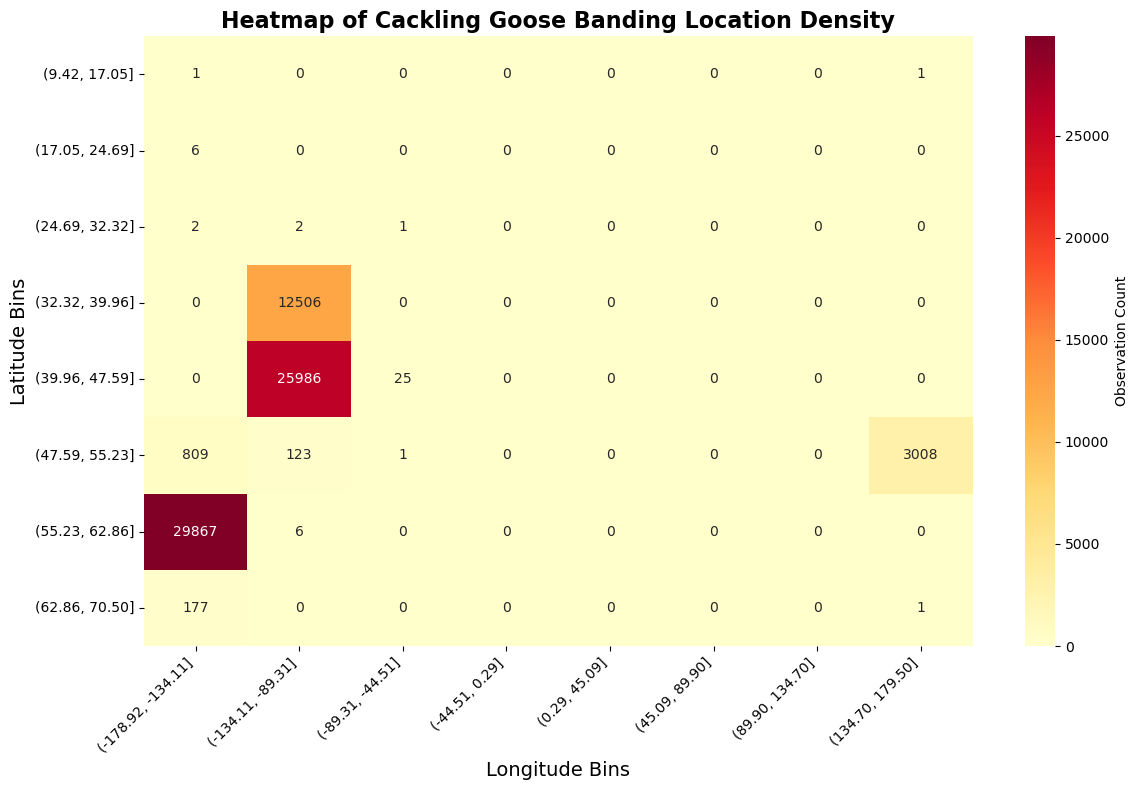

Creating heatmap with 5865410 coordinate points


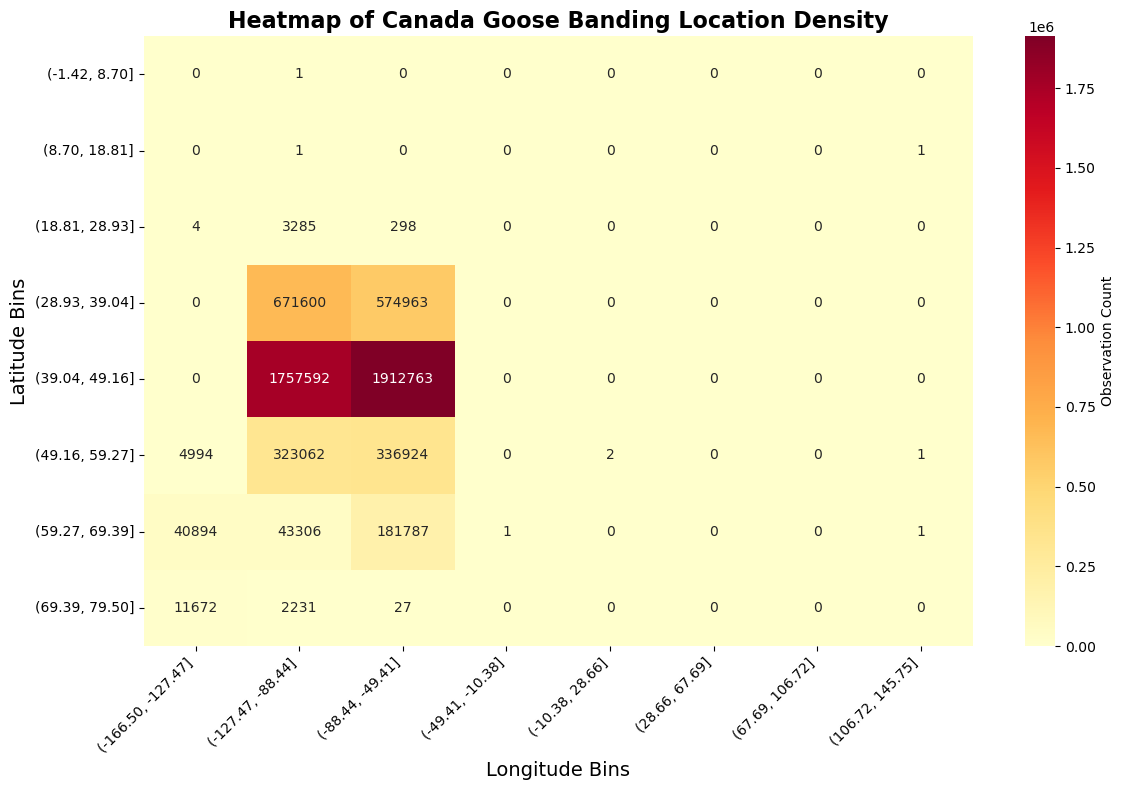

In [36]:
def create_heatmap(data, bins=8, goose_name=''):
        
    # Get coordinate values, dropping NaN
    lat_values = data['LAT_DD'].dropna().values
    lon_values = data['LON_DD'].dropna().values
    
    if len(lat_values) == 0 or len(lon_values) == 0:
        print("Error: No valid coordinate data found!")
        print(f"LAT_DD non-null count: {len(lat_values)}")
        print(f"LON_DD non-null count: {len(lon_values)}")
        return
    
    print(f"Creating heatmap with {len(lat_values)} coordinate points")
    
    # Create bins
    lat_bins = np.linspace(lat_values.min(), lat_values.max(), bins + 1)
    lon_bins = np.linspace(lon_values.min(), lon_values.max(), bins + 1)
    
    # Calculate 2D histogram
    counts, lat_edges, lon_edges = np.histogram2d(lat_values, lon_values, 
                                                  bins=[lat_bins, lon_bins])
    
    # Create bin labels
    lat_labels = [f"({lat_edges[i]:.2f}, {lat_edges[i+1]:.2f}]" 
                  for i in range(len(lat_edges)-1)]
    lon_labels = [f"({lon_edges[i]:.2f}, {lon_edges[i+1]:.2f}]" 
                  for i in range(len(lon_edges)-1)]
    
    # Create the heatmap
    plt.figure(figsize=(12, 8))
    
    sns.heatmap(counts, 
                xticklabels=lon_labels,
                yticklabels=lat_labels,
                cmap='YlOrRd',
                cbar_kws={'label': 'Observation Count'},
                annot=True,
                fmt='.0f')
    
    plt.title(f'Heatmap of {goose_name} Banding Location Density', fontsize=16, fontweight='bold')
    plt.xlabel('Longitude Bins', fontsize=14)
    plt.ylabel('Latitude Bins', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Try to create the heatmap
create_heatmap(white_fronted_goose_data, bins=8, goose_name='White Fronted Goose')
create_heatmap(snow_goose_data, bins=8, goose_name='Snow Goose')
create_heatmap(cackling_goose_data, bins=8, goose_name='Cackling Goose')
create_heatmap(canada_goose_data, bins=8, goose_name='Canada Goose')

From these histograms, we can see that sightings of the relevant goose species are likely clustered in specific areas. To confirm this, we will run a $\chi^2$ test for Uniformity on the data. This test tests the following hypotheses:

Null Hypothesis ($H_0$): Goose banding events are uniformly distributed across the geographic space (each spatial bin is equally likely to contain a banding event). 

Alternate Hypothesis ($H_A$): Goose banding events are not uniformly distributed across the geographic space.

In [37]:
def run_statistical_analysis(data, bins=8, goose_name=''):
    # Get coordinate values
    lat_values = data['LAT_DD'].dropna().values
    lon_values = data['LON_DD'].dropna().values

    if len(lat_values) == 0 or len(lon_values) == 0:
        print("Error: No valid coordinate data found!")
        return

    # Create 2D histogram
    lat_bins = np.linspace(lat_values.min(), lat_values.max(), bins + 1)
    lon_bins = np.linspace(lon_values.min(), lon_values.max(), bins + 1)
    counts, _, _ = np.histogram2d(lat_values, lon_values, bins=[lat_bins, lon_bins])

    # Filter out empty rows/columns to prevent zero expected frequencies
    counts = counts[(counts.sum(axis=1) != 0), :]  # Remove zero-rows
    counts = counts[:, (counts.sum(axis=0) != 0)]  # Remove zero-columns

    # Chi-Squared Test for uniformity
    if counts.size == 0 or counts.shape[0] < 2 or counts.shape[1] < 2:
        print("Not enough non-zero bins to perform chi-squared test.")
        return

    chi2_stat, p_value, dof, expected = chi2_contingency(counts)

    # Dataset summary statistics
    summary = {
        'num_entries': len(data),
        'num_features': data.shape[1],
        'missing_lat': data['LAT_DD'].isna().sum(),
        'missing_lon': data['LON_DD'].isna().sum(),
        'coord_unc_mean': data['COORD_UNC'].mean(),
        'coord_unc_max': data['COORD_UNC'].max(),
        'coord_unc_min': data['COORD_UNC'].min(),
        'lat_range': (data['LAT_DD'].min(), data['LAT_DD'].max()),
        'lon_range': (data['LON_DD'].min(), data['LON_DD'].max())
    }

    print(f"\nStatistical Analysis for {goose_name}:")
    print("Dataset Summary:")
    for k, v in summary.items():
        print(f"  {k}: {v}")

    print("\nChi-Squared Test for Uniformity:")
    print(f"  Chi² Statistic = {chi2_stat:.4f}")
    print(f"  p-value = {p_value:.4f}")
    print("Conclusion:", 
          "No significant spatial clustering (uniform)" if p_value > 0.05 
          else "Significant spatial clustering (non-uniform)")

# Run the analysis
run_statistical_analysis(white_fronted_goose_data, bins=8, goose_name='White Fronted Goose')
run_statistical_analysis(snow_goose_data, bins=8, goose_name='Snow Goose')
run_statistical_analysis(cackling_goose_data, bins=8, goose_name='Cackling Goose')
run_statistical_analysis(canada_goose_data, bins=8, goose_name='Canada Goose')


Statistical Analysis for White Fronted Goose:
Dataset Summary:
  num_entries: 218011
  num_features: 11
  missing_lat: 0
  missing_lon: 0
  coord_unc_mean: 0.44348620104031455
  coord_unc_max: 0.5
  coord_unc_min: 5e-06
  lat_range: (15.89525, 73.5)
  lon_range: (-166.08333, -63.91667)

Chi-Squared Test for Uniformity:
  Chi² Statistic = 386830.8625
  p-value = 0.0000
Conclusion: Significant spatial clustering (non-uniform)

Statistical Analysis for Snow Goose:
Dataset Summary:
  num_entries: 1191034
  num_features: 11
  missing_lat: 0
  missing_lon: 0
  coord_unc_mean: 0.44649442372341996
  coord_unc_max: 0.5
  coord_unc_min: 5e-06
  lat_range: (16.58333, 81.5)
  lon_range: (-179.91667, 179.91667)

Chi-Squared Test for Uniformity:
  Chi² Statistic = 697660.2548
  p-value = 0.0000
Conclusion: Significant spatial clustering (non-uniform)

Statistical Analysis for Cackling Goose:
Dataset Summary:
  num_entries: 72522
  num_features: 11
  missing_lat: 0
  missing_lon: 0
  coord_unc_mean:

For all four species tested, the $p$ value found was so small python could not store it. Therefore, it must be smaller than the $0.05$ threshold nessesary to reject the null, therefore we can conclude that there is significant spatial clustering (non-uniform). This means that certain geographic regions (likely in the Northern latitudes) are much more heavily sampled or occupied. This could be due to Goose migration patterns, Habitat availability, Research/survey effort, and/or Accessibility of locations.